In [ ]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3'
from pathlib import Path
import pickle as pkl
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image
import lovely_tensors as lt
lt.monkey_patch()
import imageio.v3 as iio
import torch

from pytorch3d.renderer import PerspectiveCameras, PointLights, MeshRenderer, MeshRasterizer, RasterizationSettings, SoftPhongShader
from pytorch3d.renderer import TexturesVertex, Materials
from pytorch3d.structures import Meshes

from hmr4d.dataset.threedpw.threedpw_motion_train import ThreedpwSmplDataset #88 samples
from hmr4d.utils.body_model import BodyModelSMPLH, BodyModelSMPLX
from hmr4d.utils.vis.renderer import Renderer, update_intrinsics_from_bbox, compute_bbox_from_points

device = 'cuda:0'

In [ ]:
smpl = BodyModelSMPLH(
    model_path="inputs/checkpoints/body_models", model_type="smpl",
    gender="neutral", num_betas=10, create_body_pose=False, 
    create_betas=False, create_global_orient=False, create_transl=False,
).to(device)
smplx = BodyModelSMPLX(
    model_path="inputs/checkpoints/body_models", model_type="smplx",
    gender="neutral", num_pca_comps=12, flat_hand_mean=False,
).to(device)
smplx2smpl = torch.load("hmr4d/utils/body_model/smplx2smpl_sparse.pt").to(device)
faces_smpl = torch.from_numpy((smpl.faces).astype("int")).unsqueeze(0).to(device)
faces_smplx = torch.from_numpy((smplx.faces).astype("int")).unsqueeze(0).to(device)
J_regressor = torch.load("hmr4d/utils/body_model/smpl_neutral_J_regressor.pt").to(device)



[12/25 16:28:37][INFO] [3DPW] Train
[12/25 16:28:37][INFO] [3DPW] has 7.5 minutes motion -> Resampled to 88 samples.


{'data_name': '3DPW', 'idx': 5, 'vid': 'courtyard_arguing_00_0', 'start_end': (174, 292)}


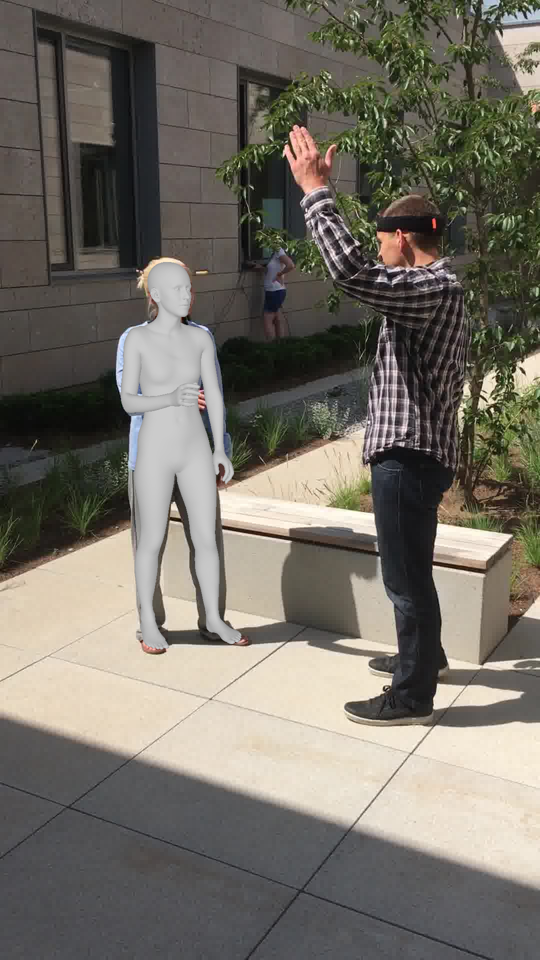

In [ ]:
dataset = ThreedpwSmplDataset()

np.random.seed(4)
batch = dataset[5]
print(batch['meta'])
og_video = Path(f"inputs/3DPW/origin/imageFiles") / "_".join(batch['meta']['vid'].split("_")[:-1])
start, end = batch['meta']['start_end']

K = batch['K_fullimg'][0].to(device)
width, height = int(K[0,2])*2, int(K[1,2])*2
smpl_params_c = {k:v.to(device) for k,v in batch['smpl_params_c'].items()}
verts = smplx(**smpl_params_c).vertices

i = 0
renderer_c = Renderer(width, height, device="cuda", faces=smplx.faces, K=K)
backg = cv2.imread(str(og_video / f"image_{i+start:05d}.jpg"))[:,:,::-1]
img = renderer_c.render_mesh(verts[i], backg, [0.8, 0.8, 0.8])
Image.fromarray(img).resize((width//2, height//2))

In [4]:
hmr4d_support_dir = Path("inputs/3DPW/hmr4d_support")
train_labels = torch.load(hmr4d_support_dir / "train_3dpw_gt_labels.pt")
refit_smplx = torch.load(hmr4d_support_dir / "train_refit_smplx.pt")
f_img_folder = hmr4d_support_dir / "imgfeats/3dpw_train_smplx_refit"

max_motion_frames = 120

seq_lengths = []
idx2meta = []
for vid in refit_smplx:
    valid_range_list = refit_smplx[vid]["valid_range_list"]
    for start, end in valid_range_list:
        seq_length = end - start
        num_samples = max(seq_length // max_motion_frames, 1)
        seq_lengths.append(seq_length)
        idx2meta.extend([(vid, start, end)] * num_samples)
minutes = sum(seq_lengths) / 25 / 60
print(f"{minutes:.1f} minutes motion -> Resampled to {len(idx2meta)} samples.")

7.7 minutes motion -> Resampled to 90 samples.


In [38]:
## threedpw_motion_train.ThreedpwSmplDataset._load_data
vid = "courtyard_arguing_00_0"
i = 184
print(vid, i)

smpl_params_c = {k: v[i].unsqueeze(0).to(device) for k, v in refit_smplx[vid]["smplx_params_incam"].items()}
K = train_labels[vid]["K_fullimg"].unsqueeze(0).float().to(device)
T_w2c = train_labels[vid]["T_w2c"][i]

# f_img_dict = torch.load(f_img_folder / f"{vid}.pt")
# bbx_xys = f_img_dict["bbx_xys"][start:end]  # (F, 3)
# f_imgseq = f_img_dict["features"][start:end].float()  # (F, 3)
# img_wh = f_img_dict["img_wh"]  # (2)
# kp2d = torch.zeros((end - start), 17, 3)  # (L, 17, 3)  # do not provide kp2d

vertices = smplx(**smpl_params_c).vertices

backg = cv2.imread(str(og_video / f"image_{i:05d}.jpg"))[:,:,::-1]

vertices[0].mean(axis=0)

courtyard_arguing_00_0 184


tensor[3] x∈[-0.434, 4.086] μ=1.078 σ=2.605 cuda:0 [-0.418, -0.434, 4.086]

In [39]:
## Renderer
width, height = int(K[0, 0, 2]) * 2, int(K[0, 1, 2]) * 2

## initialize_camera_params
R = torch.diag(torch.tensor([1, 1, 1])).float().to(device).unsqueeze(0)
T = torch.tensor([0, 0, 0]).unsqueeze(0).float().to(device)
# bboxes = torch.tensor([[0, 0, width, height]]).float()
# K_full, image_sizes = update_intrinsics_from_bbox(K, bboxes)

## update_bbox
## perspective_projection
x3d = vertices[0, ::50].unsqueeze(0).clone()
x3d = torch.matmul(R, x3d.transpose(1, 2)).transpose(1, 2)
x3d = x3d + T.unsqueeze(-1).transpose(1, 2)
x2d = torch.div(x3d, x3d[..., 2:])
x2d = torch.matmul(K, x2d.transpose(-1, -2)).transpose(-1, -2)[..., :2]
    
bboxes = compute_bbox_from_points(x2d, width, height, 1.2)
print(bboxes)
K_full, image_sizes = update_intrinsics_from_bbox(K, bboxes)
cameras = PerspectiveCameras(device=device, R=R.mT, T=T, K=K_full, image_size=image_sizes, in_ndc=False)

lights = PointLights(device=device, location=[[0.0, 0.0, -10.0]])

## create_renderer
raster_settings = RasterizationSettings(image_size=image_sizes[0], blur_radius=1e-5, bin_size=None)
rasterizer = MeshRasterizer(raster_settings=raster_settings)
shader = SoftPhongShader(device=device, lights=lights)

renderer = MeshRenderer(rasterizer=rasterizer, shader=shader)

tensor[1, 4] x∈[193.000, 1.369e+03] μ=630.250 σ=511.043 cuda:0 [[193.000, 456.000, 503.000, 1.369e+03]]


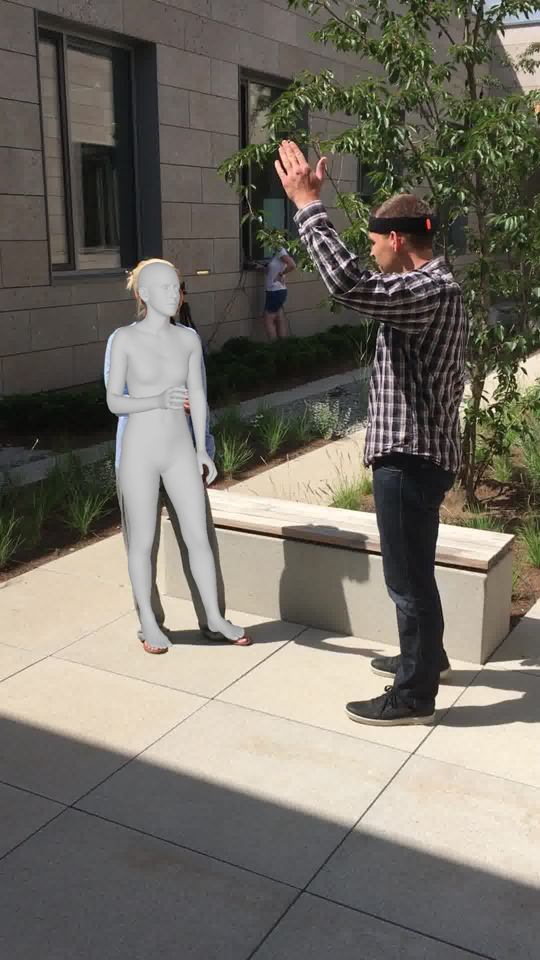

In [40]:
# img = renderer_c.render_mesh(verts[i], backg, [0.8, 0.8, 0.8])
verts_features = torch.tensor([0.8,0.8,0.8]).reshape(1, 1, 3).to(device=device, dtype=vertices.dtype)
verts_features = verts_features.repeat(1, vertices.shape[1], 1)
textures = TexturesVertex(verts_features=verts_features)

mesh = Meshes(verts=vertices, faces=faces_smplx, textures=textures,)

materials = Materials(device=device, specular_color=([0.8, 0.8, 0.8],), shininess=0)

results = torch.flip(renderer(mesh, materials=materials, cameras=cameras, lights=lights), [1, 2])
image = (results[0, ..., :3].detach().cpu().numpy() * 255).astype(np.uint8)
mask = (results[0, ..., -1].detach().cpu().numpy() > 1e-3).astype(bool)

out_image = backg.copy()
bbox = bboxes[0].int().cpu().numpy().copy()
roi_image = out_image[bbox[1]:bbox[3], bbox[0]:bbox[2]]
roi_image[mask] = image[mask]
out_image[bbox[1]:bbox[3], bbox[0]:bbox[2]] = roi_image
Image.fromarray(out_image).resize((width//2, height//2))

In [ ]:
# courtyard_arguing_00_0 174 292
vid = "courtyard_arguing_00_0"
i = 184

meta_name, meta_person = "_".join(vid.split("_")[:-1]), int(vid.split("_")[-1])
og_video = Path(f"inputs/3DPW/origin/imageFiles") / meta_name
og_meta = Path(f"inputs/3DPW/origin/sequenceFiles/train") / f"{meta_name}.pkl"
og_meta = pkl.loads(og_meta.read_bytes(), encoding='latin1')
for k,v in og_meta.items():
    if type(v) is list:
        if len(v) > 0 and type(v[0]) is np.ndarray:
            og_meta[k] = [torch.tensor(v2).float().to(device) for v2 in v]
        if len(set([len(x) for x in og_meta[k]])) == 1:
            og_meta[k] = og_meta[k][meta_person]
    elif type(v) is np.ndarray:
        og_meta[k] = torch.tensor(v).to(device)
        if og_meta[k][0].type() == 'torch.cuda.UInt16Tensor':
            og_meta[k] = og_meta[k].to(dtype=torch.int16)

K = og_meta['cam_intrinsics'][None].float().to(device)
vertices = smpl(
    betas = og_meta['betas'][None], 
    global_orient = og_meta['poses'][i, :3][None], 
    transl = og_meta['trans'][i][None], 
    body_pose = og_meta['poses'][i, 3:][None]
).vertices

R = og_meta['cam_poses'][i,:3,:3].float().to(device).unsqueeze(0)
T = og_meta['cam_poses'][i,:3,3].unsqueeze(0).float().to(device)
vertices = torch.matmul(R, vertices.transpose(1, 2)).transpose(1, 2)
vertices = vertices + T.unsqueeze(-1).transpose(1, 2)

backg = cv2.imread(str(og_video / f"image_{i:05d}.jpg"))[:,:,::-1]

tensor[3] x∈[-0.414, 4.112] μ=1.148 σ=2.568 cuda:0 [-0.414, -0.255, 4.112]

In [49]:
## Renderer
width, height = int(K[0, 0, 2]) * 2, int(K[0, 1, 2]) * 2

## initialize_camera_params
# R = og_meta['cam_poses'][i,:3,:3].float().to(device).unsqueeze(0)
# T = og_meta['cam_poses'][i,:3,3].unsqueeze(0).float().to(device)
R = torch.diag(torch.tensor([1, 1, 1])).float().to(device).unsqueeze(0)
T = torch.tensor([0, 0, 0]).unsqueeze(0).float().to(device)
# bboxes = torch.tensor([[0, 0, width, height]]).float()
# K_full, image_sizes = update_intrinsics_from_bbox(K, bboxes)

## update_bbox
## perspective_projection
x3d = vertices[0, ::50].unsqueeze(0).clone()
x3d = torch.matmul(R, x3d.transpose(1, 2)).transpose(1, 2)
x3d = x3d + T.unsqueeze(-1).transpose(1, 2)
x2d = torch.div(x3d, x3d[..., 2:])
x2d = torch.matmul(K, x2d.transpose(-1, -2)).transpose(-1, -2)[..., :2]
    
bboxes = compute_bbox_from_points(x2d, width, height, 1.2)
print(bboxes)
K_full, image_sizes = update_intrinsics_from_bbox(K, bboxes)
cameras = PerspectiveCameras(device=device, R=R.mT, T=T, K=K_full, image_size=image_sizes, in_ndc=False)

lights = PointLights(device=device, location=[[0.0, 0.0, -10.0]])

## create_renderer
raster_settings = RasterizationSettings(image_size=image_sizes[0], blur_radius=1e-5, bin_size=None)
rasterizer = MeshRasterizer(raster_settings=raster_settings)
shader = SoftPhongShader(device=device, lights=lights)

renderer = MeshRenderer(rasterizer=rasterizer, shader=shader)

tensor[1, 4] x∈[185.000, 1.384e+03] μ=631.500 σ=520.953 cuda:0 [[185.000, 449.000, 508.000, 1.384e+03]]


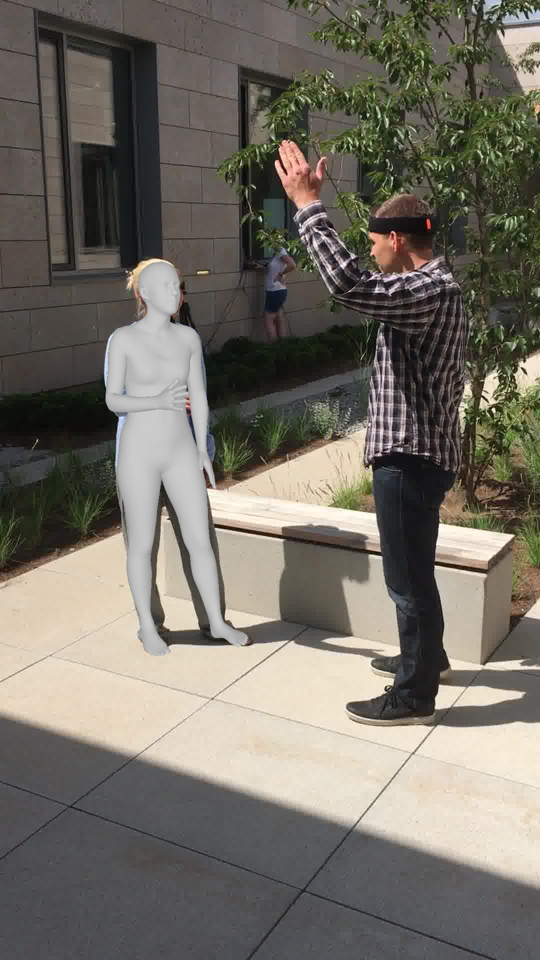

In [50]:
# img = renderer_c.render_mesh(verts[i], backg, [0.8, 0.8, 0.8])
verts_features = torch.tensor([0.8,0.8,0.8]).reshape(1, 1, 3).to(device=device, dtype=vertices.dtype)
verts_features = verts_features.repeat(1, vertices.shape[1], 1)
textures = TexturesVertex(verts_features=verts_features)

mesh = Meshes(verts=vertices, faces=faces_smpl, textures=textures,)

materials = Materials(device=device, specular_color=([0.8, 0.8, 0.8],), shininess=0.0)

results = torch.flip(renderer(mesh, materials=materials, cameras=cameras, lights=lights), [1, 2])
image = (results[0, ..., :3].detach().cpu().numpy() * 255).astype(np.uint8)
mask = (results[0, ..., -1].detach().cpu().numpy() > 1e-3).astype(bool)

out_image = backg.copy()
bbox = bboxes[0].int().cpu().numpy().copy()
roi_image = out_image[bbox[1]:bbox[3], bbox[0]:bbox[2]]
roi_image[mask] = image[mask]
out_image[bbox[1]:bbox[3], bbox[0]:bbox[2]] = roi_image
Image.fromarray(out_image).resize((width//2, height//2))